# Block Model with a 1D background - Comparison

### For the model, see the notebook BlockModel.ipynb

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
%matplotlib notebook

## Helper routines

In [3]:
def extract_lines(name):
    """Get data <name>."""
    inp = xr.load_dataset(name, engine='h5netcdf')
    print_attributes(inp)
    out = np.stack([
        inp.line_1[::2]+1j*inp.line_1[1::2],
        inp.line_2[::2]+1j*inp.line_2[1::2],
        inp.line_3[::2]+1j*inp.line_3[1::2],
    ]).T
    return out


def print_attributes(inp):
    """Print info from modeller."""
    for key in ['runtime', 'n_procs', 'max_ram',
                'n_cells', 'n_nodes', 'n_dof', 'extent',
                'min_vol', 'max_vol', 'machine',
                'version', 'date']:
        print(f"{key:10} : {inp.attrs[key]}")


def get_pos_neg(resp, off, min_off):
    """Separate positive and negative values, enforce min_off."""
    resp_pos = np.array([x if x > 0 else np.nan for x in resp])
    resp_neg = np.array([-x if x < 0 else np.nan for x in resp])

    resp_pos[off < min_offset] = np.nan
    resp_neg[off < min_offset] = np.nan

    return resp_pos, resp_neg

## Load info and data

### Survey info

In [4]:
ds = xr.load_dataset('block_model_and_survey.nc', engine='h5netcdf')
rec_x = ds.x[::2].data
rec_y = ds.attrs['rec_y']

### `empymod`: semi-analytical background responses

In [5]:
epm_1d = extract_lines('results/layered_empymod.nc')

runtime    : 0 s
n_procs    : 1
max_ram    : 0.005 GiB
n_cells    : N/A
n_nodes    : N/A
n_dof      : N/A
extent     : N/A
min_vol    : N/A
max_vol    : N/A
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 15.5 GiB of memory, Ubuntu 18.04
version    : empymod v2.0.2
date       : 2020-09-02T17:41:47.982563


### `emg3d`

In [6]:
# BACKGROUND
egd_bg = extract_lines('results/layered_emg3d.nc')
print(f"\n= - = - =  :  {14*'= - '}=\n")
# 3D BLOCK MODEL
egd_tg = extract_lines('results/block_emg3d.nc')

runtime    : 116 s
n_procs    : 1
max_ram    : 0.377 GiB
n_cells    : (256 x 64 x 96) - 1572864
n_nodes    : N/A
n_dof      : N/A
extent     : x = -57087.8-65201.2; y = -51967.8-51967.8; z = -35514.7-65482.0
min_vol    : 1000000.0
max_vol    : 2302175527498.2
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 15.5 GiB of memory, Ubuntu 18.04
version    : emg3d v0.12.0
date       : 2020-09-04T10:57:50.304951

= - = - =  :  = - = - = - = - = - = - = - = - = - = - = - = - = - = - =

runtime    : 115 s
n_procs    : 1
max_ram    : 0.364 GiB
n_cells    : (256 x 64 x 96) - 1572864
n_nodes    : N/A
n_dof      : N/A
extent     : x = -57137.8-57137.8; y = -51967.8-51967.8; z = -35514.7-65482.0
min_vol    : 1000000.0
max_vol    : 1967671391024.1
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 15.5 GiB of memory, Ubuntu 18.04
version    : emg3d v0.12.0
date       : 2020-09-04T10:52:28.593201


### `PETGEM`

In [7]:
# BACKGROUND
ptg_bg = extract_lines('results/layered_petgem.nc')
print(f"\n= - = - =  :  {14*'= - '}=\n")
# 3D BLOCK MODEL
ptg_tg = extract_lines('results/block_petgem.nc')

runtime    : 90 s
n_procs    : 24
max_ram    :  34.2 GiB
n_cells    : 385978
n_nodes    : 65131
n_dof      : 2455868
extent     : x = -100000 - 100000; y = -100000 - 100000; z = -100000 - 100000
min_vol    : 125000000.0
max_vol    : 31500000000.0
machine    : Marenostrum4. Intel Xeon Platinum from Skylake generation; 2 sockets Intel Xeon Platinum 8160 CPU with 24 cores each @2.10GHz for a total of 48 cores per node; 386 Gb DDR4 RAM per node; SuSE Linux Enterprise
version    : PETGEM v0.8
date       : 2020-07-09T21:32:46.897842

= - = - =  :  = - = - = - = - = - = - = - = - = - = - = - = - = - = - =

runtime    : 72 s
n_procs    : 24
max_ram    :  35.8 GiB
n_cells    : 385978
n_nodes    : 65131
n_dof      : 2455868
extent     : x = -100000 - 100000; y = -100000 - 100000; z = -100000 - 100000
min_vol    : 125000000.0
max_vol    : 31500000000.0
machine    : Marenostrum4. Intel Xeon Platinum from Skylake generation; 2 sockets Intel Xeon Platinum 8160 CPU with 24 cores each @2.10GHz for a t

### `custEM`

In [8]:
# BACKGROUND
#cst_bg = extract_lines('results/layered_custEM_p1.nc')
cst_bg = extract_lines('results/layered_custEM_p2.nc')
print(f"\n= - = - =  :  {14*'= - '}=\n")
# 3D BLOCK MODEL
#cst_tg = extract_lines('results/block_custEM_p1.nc')
cst_tg = extract_lines('results/block_custEM_p2.nc')

runtime    : 118 s
n_procs    : 24
max_ram    :  97.8 GiB
n_cells    : 241986
n_nodes    : 39271
n_dof      : 3061616
extent     : x = -100000 - 100000; y = -100000 - 100000; z = -100000 - 100000
min_vol    : 125000000.0
max_vol    : 31500000000.0
machine    : PowerEdge R940 server; 144 Xeon Gold 6154 CPU @2.666 GHz; ~3 TB DDR4 RAM; Ubuntu 18.04
version    : custEM v0.99.05
date       : 2020-04-03T13:14:07.743187

= - = - =  :  = - = - = - = - = - = - = - = - = - = - = - = - = - = - =

runtime    : 158 s
n_procs    : 24
max_ram    : 115.9 GiB
n_cells    : 261529
n_nodes    : 42365
n_dof      : 3308484
extent     : x = -100000 - 100000; y = -100000 - 100000; z = -100000 - 100000
min_vol    : 125000000.0
max_vol    : 31500000000.0
machine    : PowerEdge R940 server; 144 Xeon Gold 6154 CPU @2.666 GHz; ~3 TB DDR4 RAM; Ubuntu 18.04
version    : custEM v0.99.05
date       : 2020-04-03T13:14:07.768409


### `SimPEG`

In [9]:
## BACKGROUND
spg_bg = extract_lines('results/layered_simpeg_tensor.nc')
print(f"\n= - = - =  :  {14*'= - '}=\n")
# 3D BLOCK MODEL
spg_tg = extract_lines('results/block_simpeg_tensor.nc')

runtime    : 10089.103119373322
n_procs    : 1
max_ram    : 280.261 GiB
n_cells    : 1572864
n_nodes    : N/A
n_dof      : 4813216
extent     : x = -57087.8-65201.2; y = -51967.8-51967.8; z = -35514.7-65482.0
min_vol    : 1000000.0
max_vol    : 2302175527498.2
machine    : GKE n2-custom (8 vCPUs, 355 GB memory); Intel Cascade Lake; Ubuntu-1604-xenial
version    : SimPEG v0.14.2
date       : 2020-08-21T22:08:31.483035

= - = - =  :  = - = - = - = - = - = - = - = - = - = - = - = - = - = - =

runtime    : 9993.196157455444
n_procs    : 1
max_ram    : 280.586 GiB
n_cells    : 1572864
n_nodes    : N/A
n_dof      : 4813216
extent     : x = -57087.8-65201.2; y = -51967.8-51967.8; z = -35514.7-65482.0
min_vol    : 1000000.0
max_vol    : 2302175527498.2
machine    : GKE n2-custom (8 vCPUs, 355 GB memory); Intel Cascade Lake; Ubuntu-1604-xenial
version    : SimPEG v0.14.2
date       : 2020-08-24T17:56:51.549572


#### We plot data at offsets < min_offset

In [10]:
min_offset = 500

## Compare 1D background

In [11]:
# Calculate relative error (%)
error = {}
for name, data in zip(['emg3d', 'custEM', 'PETGEM', 'SimPEG'],
                      [egd_bg, cst_bg, ptg_bg, spg_bg]
                     ):
    rerr = np.clip(100*abs((epm_1d.real-data.real)/epm_1d.real), 0.01, 100)
    ierr = np.clip(100*abs((epm_1d.imag-data.imag)/epm_1d.imag), 0.01, 100)
    error[name] = rerr + 1j*ierr

<IPython.core.display.Javascript object>


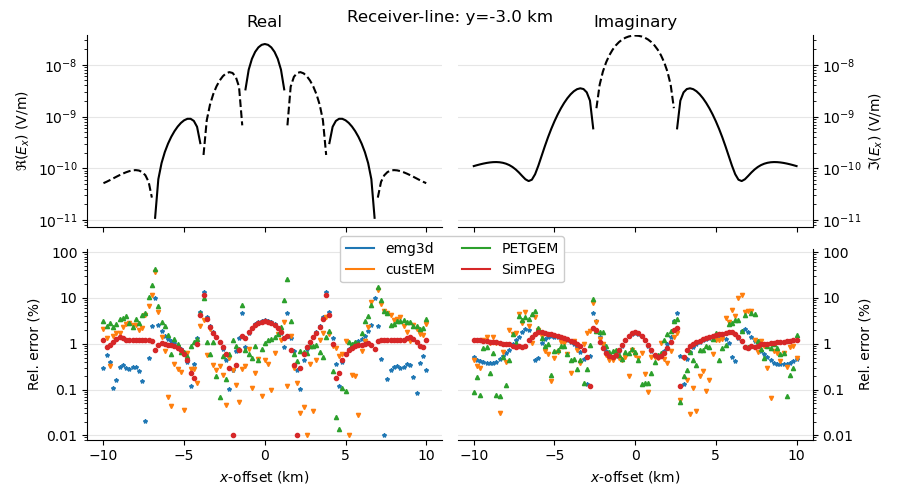

<IPython.core.display.Javascript object>


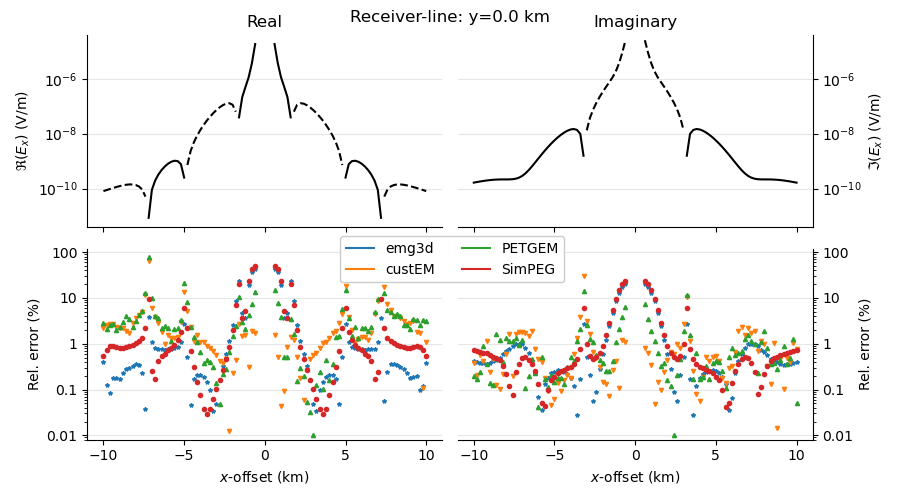

In [12]:
marker = ['*', 'v', '^', 'o']

for iy, y in enumerate(rec_y[:2]):
    
    # Get offset
    off = np.sqrt(rec_x**2 + y**2)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 5))

    # # Real
    ax1.set_title('Real')

    resp_pos, resp_neg = get_pos_neg(epm_1d[:, iy].real, off, min_offset)

    ax1.plot(rec_x/1e3, resp_pos, 'k')
    ax1.plot(rec_x/1e3, resp_neg, 'k--')

    ax1.set_yscale('log')
    ax1.set_ylabel(r'$\Re(E_x)$ (V/m)')
    ax1.set_xticklabels([])
    ax1.grid(axis='y', c='0.9')


    # # Real Relative Error
    for i, name in enumerate(error.keys()):
        error[name][off < min_offset, iy] = np.nan + 1j*np.nan
        ax3.plot(rec_x/1e3, error[name][:, iy].real, f'C{i}{marker[i]}', ms=3)

    ax3.set_yscale('log')
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_ylabel('Rel. error (%)')
    ax3.set_ylim([8e-3, 120])
    ax3.set_yticks([0.01, 0.1, 1, 10, 100])
    ax3.set_yticklabels(['0.01', '0.1', '1', '10', '100'])
    ax3.grid(axis='y', c='0.9')
    ax3.set_xlabel('$x$-offset (km)')


    # # Imaginary
    ax2.set_title('Imaginary')

    resp_pos, resp_neg = get_pos_neg(epm_1d[:, iy].imag, off, min_offset)

    ax2.plot(rec_x/1e3, resp_pos, 'k')
    ax2.plot(rec_x/1e3, resp_neg, 'k--')
    
    ax2.set_yscale('log')
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_ylabel(r'$\Im(E_x)$ (V/m)')

    ax2.set_xticklabels([])
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.grid(axis='y', c='0.9')


    # # Imaginary Error
    for i, name in enumerate(error.keys()):
        ax4.plot(rec_x/1e3, error[name][:, iy].imag, f'C{i}{marker[i]}', ms=3)

    # Legend
    for i, name in enumerate(error.keys()):
        ax4.plot(0, -1, f'C{i}', label=name)
        
    ax4.set_yscale('log')
    ax4.set_xlim(ax1.get_xlim())
    ax4.set_xlabel('$x$-offset (km)')
    ax4.set_ylabel('Rel. error (%)')
    ax4.set_ylim([8e-3, 120])
    ax4.set_yticks([0.01, 0.1, 1, 10, 100])
    ax4.set_yticklabels(['0.01', '0.1', '1', '10', '100'])
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    ax4.grid(axis='y', c='0.9')

    # Switch off spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_visible(False)

    fig.tight_layout()

    ax4.legend(loc=2, ncol=2, bbox_to_anchor=(-0.35, 1.1), framealpha=1)
    
    # fig.savefig(f'../manuscript/figures/results-layered-{int(y/1e3)}.pdf', bbox_inches='tight')
    fig.suptitle(f'Receiver-line: y={y/1e3} km')
    fig.show()

## Compare 3D model

In [13]:
# Collect data
data = {'emg3d': egd_tg, 'custEM': cst_tg, 'PETGEM': ptg_tg, 'SimPEG': spg_tg}

In [14]:
# Calculate normalized difference
ndiff = {}
for name, data1, data2 in zip(['emg3d-SimPEG', 'emg3d-custEM', 'emg3d-PETGEM',
                               'custEM-SimPEG', 'custEM-PETGEM', 'PETGEM-SimPEG'],
                              [egd_tg, egd_tg, egd_tg, cst_tg, cst_tg, ptg_tg],
                              [spg_tg, cst_tg, ptg_tg, spg_tg, ptg_tg, spg_tg],
                              ):
    rndiff = np.clip(200*abs(data1.real - data2.real) /
                     (abs(data1.real) + abs(data2.real)), 0.01, 100)
    indiff = np.clip(200*abs(data1.imag - data2.imag) /
                     (abs(data1.imag) + abs(data2.imag)), 0.01, 100)
    ndiff[name] = rndiff + 1j*indiff

<IPython.core.display.Javascript object>


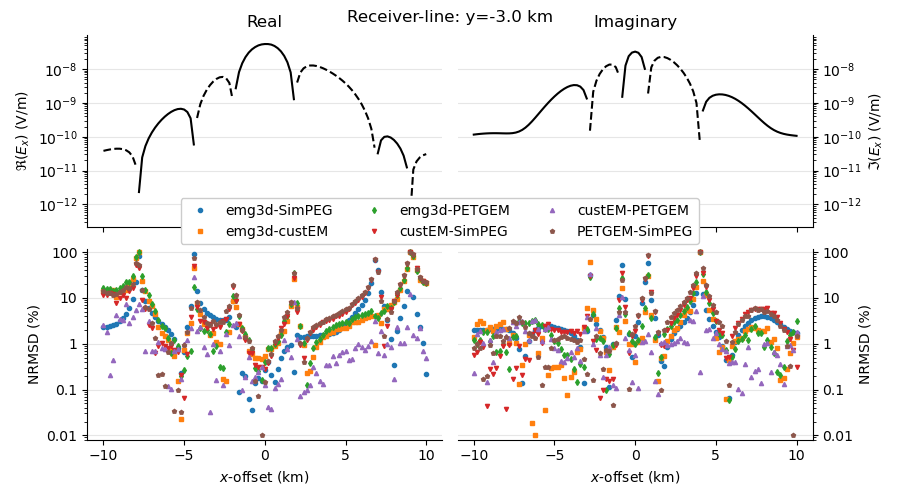

<IPython.core.display.Javascript object>


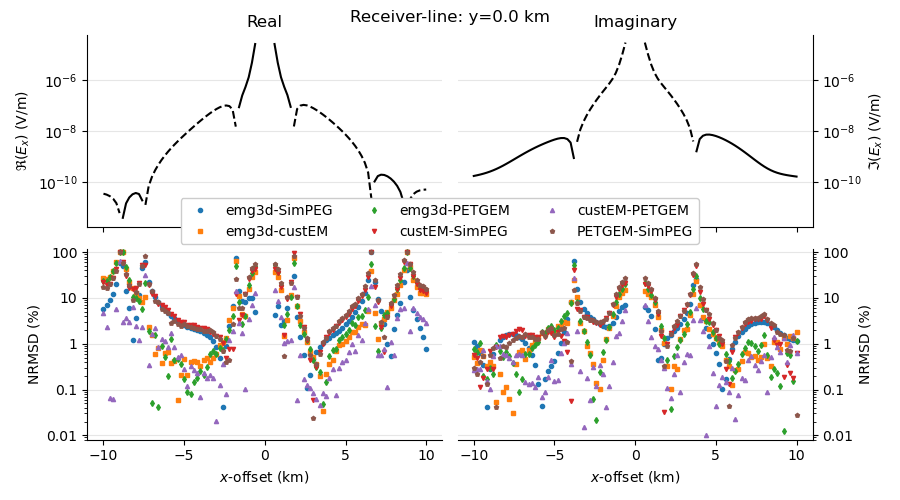

<IPython.core.display.Javascript object>


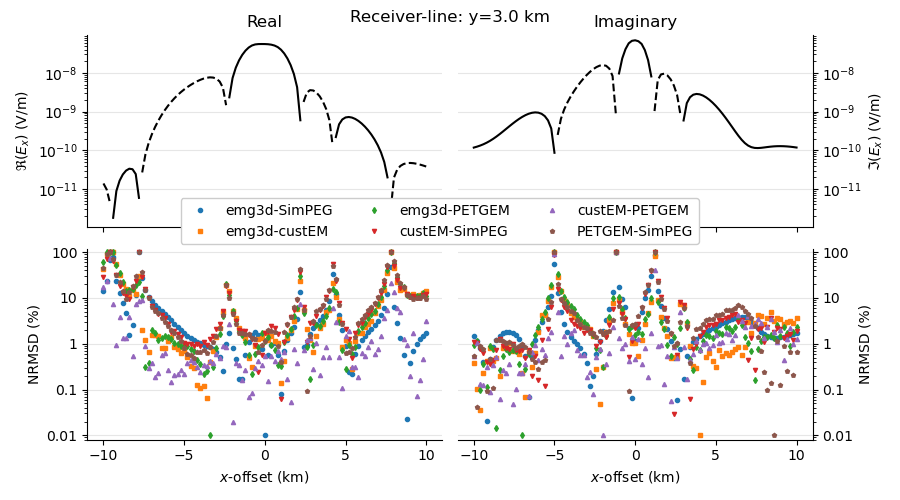

In [15]:
marker = ['o', 's', 'd', 'v', '^', 'p']

for iy, y in enumerate(rec_y):
    
    # Get offset
    off = np.sqrt(rec_x**2 + y**2)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 5))
    
    # # Real emg3d (only one, all responses overlap)
    ax1.set_title('Real')
    
    resp_pos, resp_neg = get_pos_neg(data['emg3d'][:, iy].real, off, min_offset)

    ax1.plot(rec_x/1e3, resp_pos, 'k-')   # Positive
    ax1.plot(rec_x/1e3, resp_neg, 'k--')  # Negative

    ax1.set_yscale('log')
    ax1.set_ylabel(r'$\Re(E_x)$ (V/m)')
    ax1.set_xticklabels([])
    ax1.grid(axis='y', c='0.9')

    # # Real NRMSD
    for i, name in enumerate(ndiff.keys()):
        ndiff[name][off < min_offset, iy] = np.nan + 1j*np.nan
        ax3.plot(rec_x/1e3, ndiff[name][:, iy].real, f'C{i}{marker[i]}', ms=3, label=name)

    ax3.set_yscale('log')
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_ylabel('NRMSD (%)')
    ax3.set_ylim([8e-3, 120])
    ax3.set_yticks([0.01, 0.1, 1, 10, 100])
    ax3.set_yticklabels(['0.01', '0.1', '1', '10', '100'])
    ax3.grid(axis='y', c='0.9')
    ax3.set_xlabel('$x$-offset (km)')


    # # Imaginary
    ax2.set_title('Imaginary')

    resp_pos, resp_neg = get_pos_neg(data['emg3d'][:, iy].imag, off, min_offset)
    
    ax2.plot(rec_x/1e3, resp_pos, 'k-', label=name)
    ax2.plot(rec_x/1e3, resp_neg, 'k--')
    
    ax2.set_yscale('log')
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_ylabel(r'$\Im(E_x)$ (V/m)')

    ax2.set_xticklabels([])
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.grid(axis='y', c='0.9')


    # # Imaginary NRMSD
    for i, name in enumerate(ndiff.keys()):
        ax4.plot(rec_x/1e3, ndiff[name][:, iy].imag, f'C{i}{marker[i]}', ms=3, label=name)

    ax4.set_yscale('log')
    ax4.set_xlim(ax1.get_xlim())
    ax4.set_xlabel('$x$-offset (km)')
    ax4.set_ylabel('NRMSD (%)')
    ax4.set_ylim([8e-3, 120])
    ax4.set_yticks([0.01, 0.1, 1, 10, 100])
    ax4.set_yticklabels(['0.01', '0.1', '1', '10', '100'])
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    ax4.grid(axis='y', c='0.9')

    # Switch off spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_visible(False)

    fig.tight_layout()

    ax4.legend(loc=2, ncol=3, bbox_to_anchor=(-0.8, 1.3), framealpha=1)

    # fig.savefig(f'../manuscript/figures/results-block-{int(y/1e3)}.pdf', bbox_inches='tight')
    fig.suptitle(f'Receiver-line: y={y/1e3} km')
    fig.show()

## Stats plot

In [16]:
ldata = [egd_tg, spg_tg, cst_tg, ptg_tg]
# Calculate normalized difference between all models
medians = np.ones((len(ldata), len(ldata)))*np.nan
for i,  d1 in enumerate(ldata):
    for j, d2 in enumerate(ldata):
        if i > j:
            medians[i, j] = np.median(200*abs(d1.real - d2.real) /
                             (abs(d1.real) + abs(d2.real)))
        elif j > i:
            medians[i, j] = np.median(200*abs(d1.imag - d2.imag) /
                             (abs(d1.imag) + abs(d2.imag)))

<IPython.core.display.Javascript object>


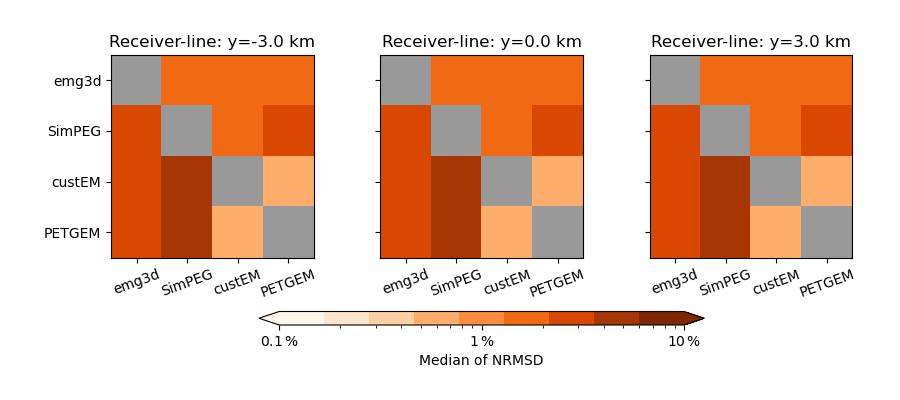

In [17]:
M, N = np.meshgrid(np.arange(medians.shape[0]+1), np.arange(medians.shape[1]+1))

labels = ['emg3d', 'SimPEG', 'custEM', 'PETGEM']
cmap = plt.cm.get_cmap('Oranges', 9)
cmap.set_bad(color = '0.6', alpha = 1.) # main diagonal irrelevant

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 4))
    
for iy, y in enumerate(rec_y):
    
    ax = axs[iy]
    ax.set_title(f'Receiver-line: y={y/1e3} km')

    obj = ax.pcolormesh(M, N, medians, cmap=cmap, norm=LogNorm(vmin=1e-1, vmax=1e1))

    ax.set_yticks(np.arange(len(ldata)) + 0.5)
    ax.set_yticklabels(labels)
    ax.set_xticks(np.arange(len(ldata)) + 0.5)
    ax.set_xticklabels(labels, rotation=20, horizontalalignment='center')

#    ax.xaxis.tick_top()
    ax.set_xlim([0., 4])
    ax.set_ylim([4, 0.])
    ax.axis('equal')
    ax.set_adjustable('box')
    
fig.tight_layout(w_pad=0, rect=[0, 0.15, 1, 0.9])

# Plot combined colorbar
cax, kw = plt.matplotlib.colorbar.make_axes(
    axs, location='bottom', fraction=.05, pad=0.2, aspect=30)
cb = plt.colorbar(obj, cax=cax, extend='both', label=r'Median of NRMSD', **kw)
cb.set_ticks([1e-1, 1e0, 1e1])  
cb.ax.set_xticklabels([r"$0.1\,\%$", r"$1\,\%$", r"$10\,\%$"])

# fig.savefig(f'../manuscript/figures/median-stats-block.pdf', bbox_inches='tight')
fig.show()